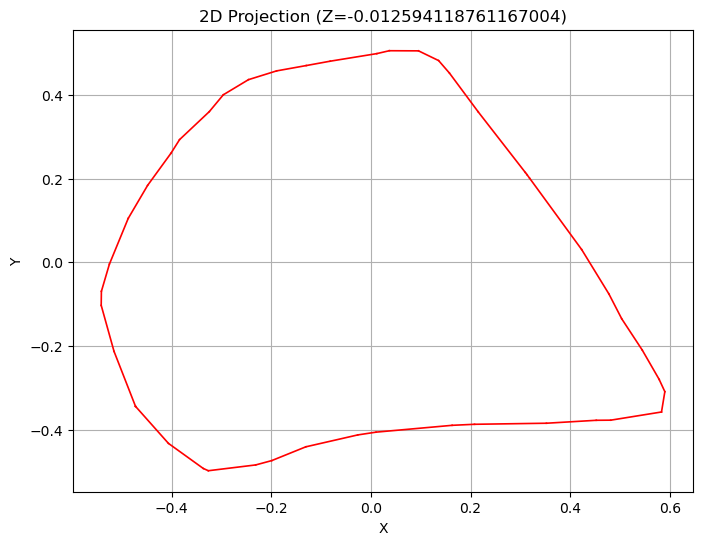

In [ ]:
from stl import mesh
import numpy as np
import matplotlib.pyplot as plt 


def intersect_with_z_plane(your_mesh, z0=None):
    
    segments = []

    triangles = your_mesh.vectors

    if z0 is None:
        z0 = your_mesh.get_mass_properties()[1][2]

    for tri in triangles:
        points = []

        for i in range(3):
            p1 = tri[i]
            p2 = tri[(i + 1) % 3]

            z1, z2 = p1[2], p2[2]

            if (z1 - z0) * (z2 - z0) < 0:  # The edge crosses the Z=0 plane
                t = (z0 - z1) / (z2 - z1)
                intersection_point = p1 + t * (p2 - p1)
                points.append(intersection_point)

            elif z1 == z0 and z2 != z0:
                points.append(p1)
            elif z2 == z0 and z1 != z0:
                points.append(p2)

        if len(points) == 2:
            segments.append(points)

    return segments


def plot_segments_2d(segments, z0=None):

    z0 = 0.0 if z0 is None else z0
   
    plt.figure(figsize=(8, 6))

    # Plot the intersection points
    segments_2d = [[(point[0], point[1]) for point in segment] for segment in segments]

    for segment in segments_2d:
        x_coords, y_coords = zip(*segment)
        plt.plot(x_coords, y_coords, color='red', linewidth=1.2)

    # Set limits and labels
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'2D Projection (Z={z0})')
    plt.grid(True)

    plt.show()

if __name__ == "__main__":
    # Load the mesh from a file
    your_mesh = mesh.Mesh.from_file('data/D2_8_0.30_par0.stl')

    # Intersect the mesh with the z=0 plane
    segments = intersect_with_z_plane(your_mesh)

    # Plot the mesh and intersection points
    plot_segments_2d(segments, z0=your_mesh.get_mass_properties()[1][2])
    # Save the intersection points to a file

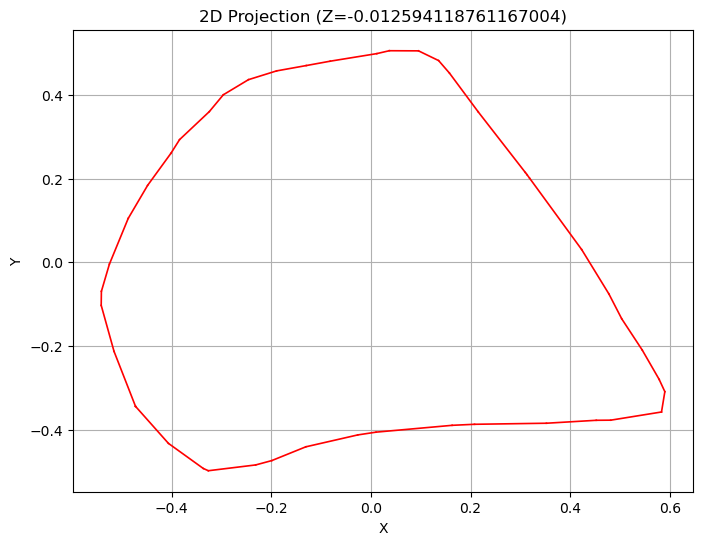

[-0.01419241 -0.01647323 -0.01259412] 46


In [38]:
your_mesh = mesh.Mesh.from_file('data/D2_8_0.30_par0.stl')


center = your_mesh.get_mass_properties()[1]


segments = intersect_with_z_plane(your_mesh, z0=center[2])
plot_segments_2d(segments, z0=center[2])

print(center, len(segments))

Center of mass: (-0.026731907383535414, -0.03146133751582089)
Center of mass after shifting: (-6.637202864606914e-17, 7.512106878577825e-17)


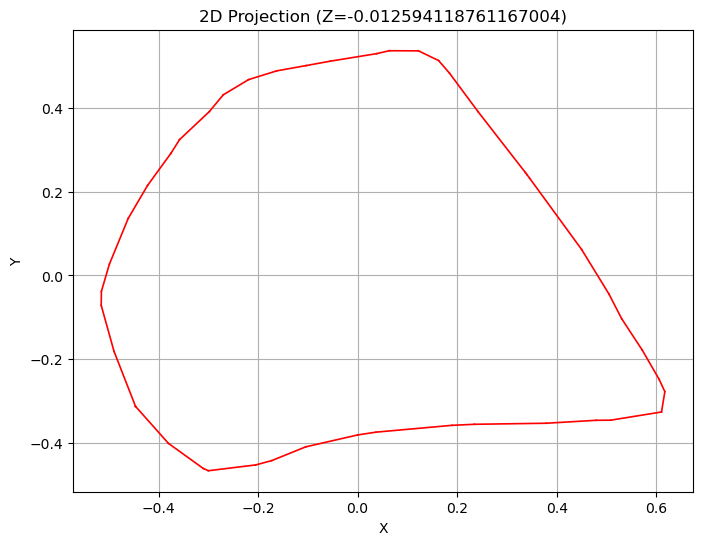

In [42]:
segments_2d = [[point[0:2] for point in segment] for segment in segments]

def center_of_mass(segments_2d):
    x_coords = []
    y_coords = []

    for segment in segments_2d:
        for point in segment:
            x_coords.append(point[0])
            y_coords.append(point[1])

    x_center = sum(x_coords) / len(x_coords)
    y_center = sum(y_coords) / len(y_coords)

    return x_center, y_center


# Calculate the center of mass
x_center, y_center = center_of_mass(segments_2d)
print(f"Center of mass: ({x_center}, {y_center})")

# Shift the segments to make the center of mass (cm) as (0, 0)
shifted_segments_2d = [[[point[0] - x_center, point[1] - y_center] for point in segment] for segment in segments_2d]
x_center_shifted, y_center_shifted = center_of_mass(shifted_segments_2d)
print(f"Center of mass after shifting: ({x_center_shifted}, {y_center_shifted})")

plot_segments_2d(shifted_segments_2d, z0=center[2])

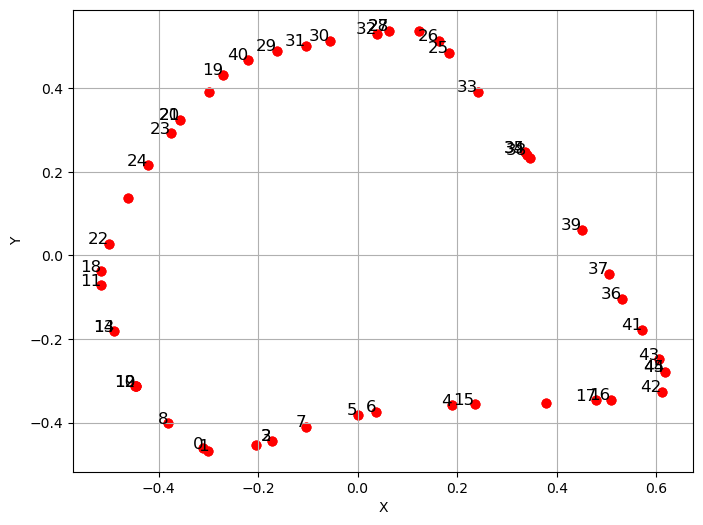

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the shifted_segments_2d in scatter with text as index
for i, segment in enumerate(shifted_segments_2d):
    x_coords, y_coords = zip(*segment)
    ax.scatter(x_coords, y_coords, color='red', linewidth=1.2)
    ax.text(x_coords[0], y_coords[0], str(i), fontsize=12, ha='right')
# Set limits and labels

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid(True)      
plt.show()


In [51]:
import numpy as np

offset = 0.002
# Calculate the largest distance
R = max(
    np.linalg.norm(np.array(point) - np.array([x_center_shifted, y_center_shifted])) for segment in shifted_segments_2d for point in segment
) + offset

print(f"Largest distance (R): {R}")


Largest distance (R): 0.694175568013418


In [ ]:
def create_boundary_nodes(n_bn:int, radius:float, center:np.ndarray, line_segments:np.ndarray) -> np.ndarray:
    """
    Create boundary nodes for a circular boundary.
    
    Parameters
    ----------
    n_bn : int
        Number of boundary nodes.
    radius : float
        Radius of the circle.
    center : np.ndarray
        Center of the circle.
    line_segments : np.ndarray
        Line segments defining the boundary.
    
    Returns
    -------
    np.ndarray
        Array of boundary nodes.
    """
    
    # Create an array of angles for the boundary nodes
    nc = []
    intersected_nc = []

    for i in range(n_bn):
        angle = 2 * np.pi * i / n_bn
        x = center[0] + radius * np.cos(angle)
        y = center[1] + radius * np.sin(angle)
        nc.append([x, y])

Number of intersection points: 0


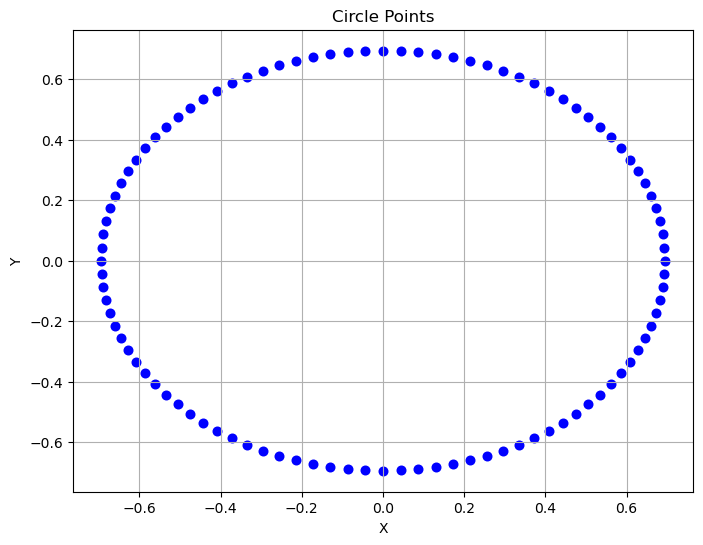

92 46 100


In [ ]:
def create_circle(n_bn: int, radius: float, center: np.ndarray):
    nc = []
    for i in range(n_bn):
        angle = 2 *  np.pi / n_bn * i
        nc.append(
            [
                radius * np.cos(angle) + center[0],
                radius * np.sin(angle) + center[1],
            ]
        )
    return nc


n_bn = 100
radius = R
center = np.array([x_center_shifted, y_center_shifted])
circle_points = create_circle(n_bn, radius, center)

def plot_circle(circle_points):
    plt.figure(figsize=(8, 6))
    x_coords, y_coords = zip(*circle_points)
    plt.scatter(x_coords, y_coords, color='blue', linewidth=1.2)

    # Set limits and labels
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Circle Points')
    plt.grid(True)

    plt.show()
    
plot_circle(circle_points)

68 46 100


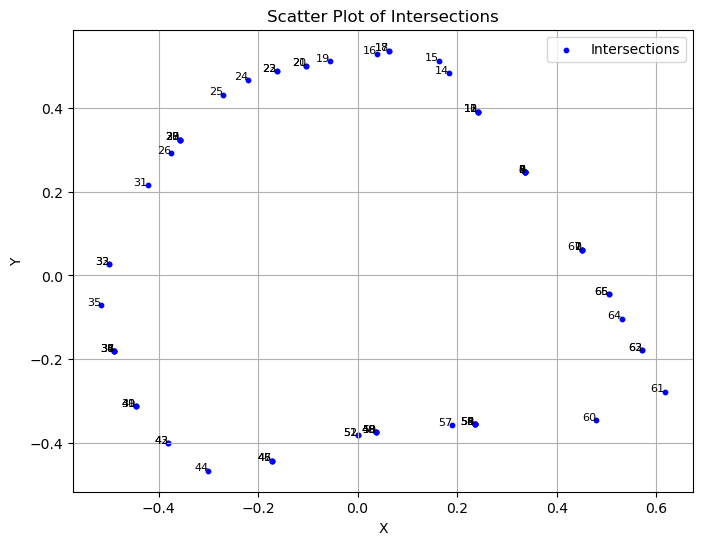

In [113]:

def intersected_boundary_nodes(segments_2d, circle_points, cm):
    """
    Find the intersection points between the segments and the circle.
    """
    intersections = []
    x1, y1 = cm
    
    for nc in circle_points:
        x2, y2 = nc
        for segment in segments_2d:
            x3, y3 = segment[0]
            x4, y4 = segment[1]

            t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / ((x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4))

            if 0 <= t <= 1:
                u = ((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / ((x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4))

                if 0 <= u <= 1:
                    # intersection_x = x1 + t * (x2 - x1)
                    # intersection_y = y1 + t * (y2 - y1)
                    # intersection_x = x3 + t * (x4 - x3)
                    # intersection_y = y3 + t * (y4 - y3)
                    xi = ((x3 + u * (x4-x3)) + (x1 + t * (x2-x1))) / 2; 
                    yi = ((y3 + u * (y4-y3)) + (y1 + t * (y2-y1))) / 2;
                    intersections.append([xi, yi])
                    break

    return intersections

intersections = intersected_boundary_nodes(shifted_segments_2d, circle_points, center)


print(len(intersections), len(shifted_segments_2d), len(circle_points))


# Extract x and y coordinates from intersections
x_coords = [point[0] for point in intersections]
y_coords = [point[1] for point in intersections]

# Plot the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords, color='blue', label='Intersections', s=10)

for i, point in enumerate(intersections):
    plt.text(point[0], point[1], str(i), fontsize=8, ha='right')

# Add labels, title, and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of Intersections')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
x1, y1 = (1, 4)
x2, y2 = (6, 0)

# x1, y1 = (6, 0)
# x2, y2 = (1, 4)

x3, y3 = (1, 1)
x4, y4 = (6, 2)
t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / ((x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4))
u = ((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / ((x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4))

print(f"t: {t}, u: {u}")   
xi = 0
yi = 0

if (0 <= u <= 1.0) and (0 <= t <= 1.0):
    xi = x3 + t * (x4 - x3)
    yi = y3 + t * (y4 - y3)
    # xi = ((x3 + u * (x4-x3)) + (x1 + t * (x2-x1))) / 2; 
    # yi = ((y3 + u * (y4-y3)) + (y1 + t * (y2-y1))) / 2;

 
print(f"Intersection point: ({xi}, {yi})")

t: 0.6, u: -0.6
Intersection point: (0, 0)


In [99]:
# x1, y1 = (1, 4)
# x2, y2 = (6, 0)

x1, y1 = (6, 0)
x2, y2 = (1, 4)

x3, y3 = (1, 1)
x4, y4 = (6, 2)
t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / ((x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4))
u = ((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / ((x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4))


int_x = x3 + t * (x4 - x3)
int_y = y3 + t * (y4 - y3)

print(f"Intersection point: ({int_x}, {int_y})")

Intersection point: (3.0, 1.4)


In [110]:
# x1, y1 = (1, 4)
# x2, y2 = (6, 0)

x1, y1 = (6, 0)
x2, y2 = (1, 4)

x3, y3 = (1, 1)
x4, y4 = (6, 2)


m = x2 - x1
n = x4 - x3
a = x3 - x1
o = y2 - y1
p = y4 - y3
b = y3 - y1

t = (b * m  - o * a) / (o * n - m * p)
s = (a  + n * t) / m

print(f"t: {t}, s: {s}")

t: 0.6, s: 0.4
